# Exploratory Data Analysis: Singapore Job Market Data

This notebook documents the exploratory data analysis (EDA) performed on the SGJobData dataset,
which contains over 1 million job postings from the Singapore job market.

**Objectives:**
- Understand the structure, quality, and characteristics of the dataset
- Identify data quality issues and document cleaning decisions
- Discover patterns in salary, hiring, and engagement metrics
- Inform dashboard design decisions with data-driven insights

**Tools:** DuckDB (in-memory OLAP), Pandas, Matplotlib, Seaborn

---
## 1. Setup & Data Loading

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Connect to DuckDB in-memory
con = duckdb.connect(':memory:')
print('DuckDB version:', duckdb.__version__)

DuckDB version: 1.4.4


In [2]:
# Load CSV data into staging table (no filters — raw data as-is)
con.execute("""
    CREATE TABLE jobs_staging AS
    SELECT * FROM read_csv_auto('../data/raw/SGJobData.csv', header=true, sample_size=-1)
""")

raw_count = con.execute('SELECT COUNT(*) FROM jobs_staging').fetchone()[0]
print(f'Loaded {raw_count:,} rows into jobs_staging (raw, unfiltered)')

Loaded 1,048,585 rows into jobs_staging (raw, unfiltered)


In [3]:
# Verify raw row count and basic table info
col_count = con.execute("SELECT COUNT(*) FROM information_schema.columns WHERE table_name = 'jobs_staging'").fetchone()[0]
print(f'Raw dataset: {raw_count:,} rows x {col_count} columns')

Raw dataset: 1,048,585 rows x 22 columns


---
## 1b. Data Cleaning: Identify & Remove Empty/Invalid Rows

Before analysis, we inspect the raw data for empty, placeholder, or invalid rows and clean them.
This step ensures downstream analysis is not skewed by garbage data.

In [4]:
# Step 1: Identify empty/invalid rows in the raw data
print('=== Empty / Invalid Row Analysis ===\n')

checks = [
    ("metadata_jobPostId IS NULL", "NULL job ID (no identifier)"),
    ("title IS NULL OR TRIM(title) = ''", "Empty title"),
    ("postedCompany_name IS NULL OR TRIM(postedCompany_name) = ''", "Empty company name"),
    ("salary_minimum = 0 AND salary_maximum = 0", "Both salaries = 0"),
    ("average_salary = 0", "Zero average salary"),
    ("salary_minimum = 1 AND salary_maximum = 1 AND average_salary = 1", "Placeholder salary (min=1, max=1, avg=1)"),
    ("numberOfVacancies = 0", "Zero vacancies"),
    ("categories IS NULL OR TRIM(categories) = '' OR categories = '[]'", "Empty categories"),
]

results = []
for condition, label in checks:
    cnt = con.execute(f"SELECT COUNT(*) FROM jobs_staging WHERE {condition}").fetchone()[0]
    pct = cnt / raw_count * 100
    results.append({'Issue': label, 'Row Count': cnt, '% of Total': round(pct, 2)})
    print(f'  {label:45s} {cnt:>10,} rows ({pct:.2f}%)')

print(f'\n  {"Total raw rows":45s} {raw_count:>10,}')

issues_df = pd.DataFrame(results)
issues_df

=== Empty / Invalid Row Analysis ===

  NULL job ID (no identifier)                        3,988 rows (0.38%)
  Empty title                                        3,988 rows (0.38%)
  Empty company name                                 3,988 rows (0.38%)
  Both salaries = 0                                  3,988 rows (0.38%)
  Zero average salary                                3,988 rows (0.38%)
  Placeholder salary (min=1, max=1, avg=1)           1,804 rows (0.17%)
  Zero vacancies                                     3,988 rows (0.38%)
  Empty categories                                   3,988 rows (0.38%)

  Total raw rows                                 1,048,585


,Issue,Row Count,% of Total
0,NULL job ID (no identifier),3988,0.38
1,Empty title,3988,0.38
2,Empty company name,3988,0.38
3,Both salaries = 0,3988,0.38
4,Zero average salary,3988,0.38
5,"Placeholder salary (min=1, max=1, avg=1)",1804,0.17
6,Zero vacancies,3988,0.38
7,Empty categories,3988,0.38


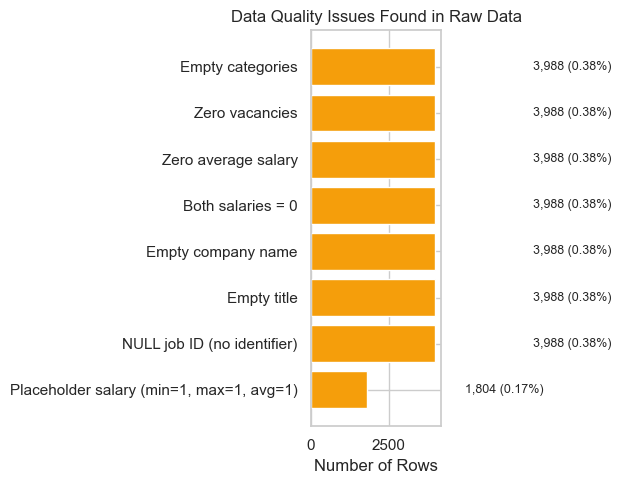

In [5]:
# Visualize data quality issues
fig, ax = plt.subplots(figsize=(12, 5))
plot_issues = issues_df[issues_df['Row Count'] > 0].sort_values('Row Count')

colors = ['#EF4444' if cnt > raw_count * 0.01 else '#F59E0B' if cnt > 100 else '#10B981'
          for cnt in plot_issues['Row Count']]
bars = ax.barh(plot_issues['Issue'], plot_issues['Row Count'], color=colors)

for bar, pct in zip(bars, plot_issues['% of Total']):
    ax.text(bar.get_width() + raw_count * 0.003, bar.get_y() + bar.get_height()/2,
            f'{int(bar.get_width()):,} ({pct}%)', va='center', fontsize=9)

ax.set_xlabel('Number of Rows')
ax.set_title('Data Quality Issues Found in Raw Data')
plt.tight_layout()
plt.show()

In [6]:
# Step 2: Inspect the empty rows — are they all the same set?
print('=== Do the empty rows overlap? ===\n')

overlap = con.execute("""
    SELECT COUNT(*) as cnt FROM jobs_staging
    WHERE metadata_jobPostId IS NULL
      AND (title IS NULL OR TRIM(title) = '')
      AND salary_minimum = 0 AND salary_maximum = 0
      AND (postedCompany_name IS NULL OR TRIM(postedCompany_name) = '')
      AND numberOfVacancies = 0
""").fetchone()[0]
print(f'Rows matching ALL empty criteria simultaneously: {overlap:,}')
print(f'Rows with NULL job ID:                           {con.execute("SELECT COUNT(*) FROM jobs_staging WHERE metadata_jobPostId IS NULL").fetchone()[0]:,}')
print(f'=> The {overlap:,} completely empty rows are the SAME set as NULL job ID rows.\n')

# Preview sample empty rows
print('=== Sample of completely empty rows ===')
sample_empty = con.execute("""
    SELECT title, postedCompany_name, salary_minimum, salary_maximum,
           average_salary, numberOfVacancies, categories, metadata_jobPostId
    FROM jobs_staging
    WHERE metadata_jobPostId IS NULL
    LIMIT 5
""").fetchdf()
display(sample_empty)

# Check placeholder salary rows (min=1, max=1) — these survive the NULL filter
print('\n=== Sample of placeholder salary rows (min=1, max=1, avg=1) ===')
sample_placeholder = con.execute("""
    SELECT title, postedCompany_name, salary_minimum, salary_maximum,
           average_salary, positionLevels, categories
    FROM jobs_staging
    WHERE metadata_jobPostId IS NOT NULL
      AND salary_minimum = 1 AND salary_maximum = 1 AND average_salary = 1
    LIMIT 5
""").fetchdf()
display(sample_placeholder)

placeholder_count = con.execute("""
    SELECT COUNT(*) FROM jobs_staging
    WHERE metadata_jobPostId IS NOT NULL
      AND salary_minimum = 1 AND salary_maximum = 1 AND average_salary = 1
""").fetchone()[0]
print(f'\nTotal placeholder salary rows: {placeholder_count:,} ({placeholder_count/raw_count*100:.2f}%)')
print('These are real jobs where salary was not disclosed (SGD $1 is a placeholder).')

=== Do the empty rows overlap? ===

Rows matching ALL empty criteria simultaneously: 3,988
Rows with NULL job ID:                           3,988
=> The 3,988 completely empty rows are the SAME set as NULL job ID rows.

=== Sample of completely empty rows ===


,title,postedCompany_name,salary_minimum,salary_maximum,average_salary,numberOfVacancies,categories,metadata_jobPostId
0,None,None,0,0,0.0,0,None,None
1,None,None,0,0,0.0,0,None,None
2,None,None,0,0,0.0,0,None,None
3,None,None,0,0,0.0,0,None,None
4,None,None,0,0,0.0,0,None,None



=== Sample of placeholder salary rows (min=1, max=1, avg=1) ===


,title,postedCompany_name,salary_minimum,salary_maximum,average_salary,positionLevels,categories
0,Educational Therapist - Internship,OLIVE TREE INTERVENTION CENTRE PTE. LTD.,1,1,1.0,Fresh/entry level,"[{""id"":10,""category"":""Education and Training""}]"
1,Executive or Senior Executive (Family and Work...,CHINESE DEVELOPMENT ASSISTANCE COUNCIL,1,1,1.0,Executive,"[{""id"":38,""category"":""Social Services""}]"
2,"Driver (Mon-Fri : 1pm to 7pm, Sat : 6am to 12pm)",THYE HUA KWAN NURSING HOME LIMITED,1,1,1.0,Non-executive,"[{""id"":18,""category"":""Healthcare / Pharmaceuti..."
3,Project Manager,YUAN XIANG PTE. LTD.,1,1,1.0,Manager,"[{""id"":6,""category"":""Building and Construction..."
4,Centre Supervisor (Student Care),Life Community Services Society,1,1,1.0,Senior Executive,"[{""id"":10,""category"":""Education and Training""}..."



Total placeholder salary rows: 1,804 (0.17%)
These are real jobs where salary was not disclosed (SGD $1 is a placeholder).


In [7]:
# Step 3: Clean the data — remove empty rows and handle placeholder salaries
print('=== Data Cleaning ===\n')

# Remove completely empty rows (NULL job ID) and placeholder salary rows
con.execute("""
    CREATE TABLE jobs_raw AS
    SELECT * FROM jobs_staging
    WHERE metadata_jobPostId IS NOT NULL          -- Remove 3,988 empty rows
      AND NOT (salary_minimum = 1
               AND salary_maximum = 1
               AND average_salary = 1)            -- Remove placeholder salary rows
""")

cleaned_count = con.execute('SELECT COUNT(*) FROM jobs_raw').fetchone()[0]
empty_removed = raw_count - cleaned_count
placeholder_removed = con.execute("""
    SELECT COUNT(*) FROM jobs_staging
    WHERE metadata_jobPostId IS NOT NULL
      AND salary_minimum = 1 AND salary_maximum = 1 AND average_salary = 1
""").fetchone()[0]
null_id_removed = raw_count - con.execute(
    "SELECT COUNT(*) FROM jobs_staging WHERE metadata_jobPostId IS NOT NULL"
).fetchone()[0]

print(f'Cleaning steps applied:')
print(f'  1. Removed rows with NULL job ID (completely empty): {null_id_removed:,} rows')
print(f'  2. Removed placeholder salary rows (min=1, max=1, avg=1): {placeholder_removed:,} rows')
print(f'  ---')
print(f'  Total rows removed: {empty_removed:,} ({empty_removed/raw_count*100:.2f}%)')
print(f'  Remaining rows:     {cleaned_count:,}')

# Update row_count for downstream use
row_count = cleaned_count

=== Data Cleaning ===



Cleaning steps applied:
  1. Removed rows with NULL job ID (completely empty): 3,988 rows
  2. Removed placeholder salary rows (min=1, max=1, avg=1): 1,804 rows
  ---
  Total rows removed: 5,792 (0.55%)
  Remaining rows:     1,042,793


=== Before vs After Cleaning ===

Check                                          Before        After      Removed
NULL job ID                                     3,988            0        3,988
Empty title                                     3,988            0        3,988
Empty company                                   3,988            0        3,988
Both salaries = 0                               3,988            0        3,988
Placeholder salary (1/1/1)                      1,804            0        1,804
Zero average salary                             3,988            0        3,988
Zero vacancies                                  3,988            0        3,988
TOTAL ROWS                                  1,048,585    1,042,793        5,792


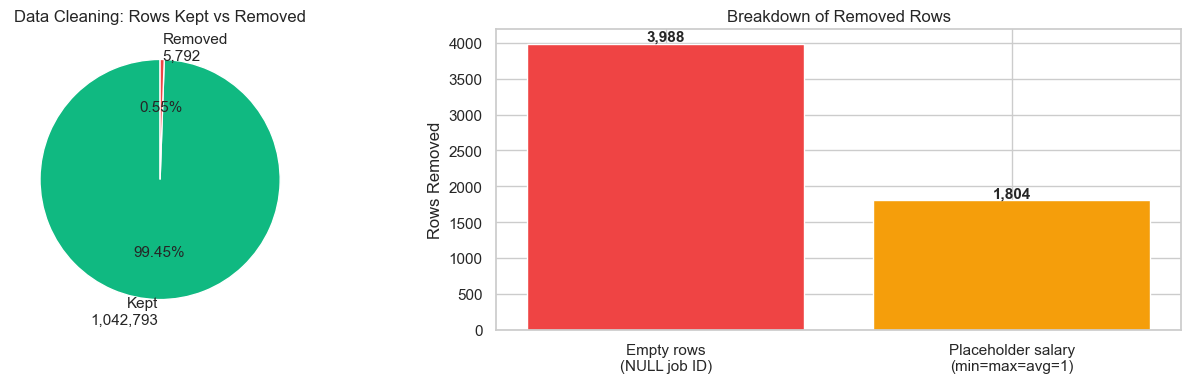

In [8]:
# Step 4: Verify cleaning — before vs after comparison
print('=== Before vs After Cleaning ===\n')

verify_checks = [
    ("metadata_jobPostId IS NULL", "NULL job ID"),
    ("title IS NULL OR TRIM(title) = ''", "Empty title"),
    ("postedCompany_name IS NULL OR TRIM(postedCompany_name) = ''", "Empty company"),
    ("salary_minimum = 0 AND salary_maximum = 0", "Both salaries = 0"),
    ("salary_minimum = 1 AND salary_maximum = 1 AND average_salary = 1", "Placeholder salary (1/1/1)"),
    ("average_salary = 0", "Zero average salary"),
    ("numberOfVacancies = 0", "Zero vacancies"),
]

print(f'{"Check":<40s} {"Before":>12s} {"After":>12s} {"Removed":>12s}')
print('=' * 78)
for cond, label in verify_checks:
    before = con.execute(f"SELECT COUNT(*) FROM jobs_staging WHERE {cond}").fetchone()[0]
    after = con.execute(f"SELECT COUNT(*) FROM jobs_raw WHERE {cond}").fetchone()[0]
    print(f'{label:<40s} {before:>12,} {after:>12,} {before - after:>12,}')

print('=' * 78)
print(f'{"TOTAL ROWS":<40s} {raw_count:>12,} {cleaned_count:>12,} {raw_count - cleaned_count:>12,}')

# Visualize before/after
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Pie chart: kept vs removed
removed = raw_count - cleaned_count
axes[0].pie([cleaned_count, removed],
            labels=[f'Kept\n{cleaned_count:,}', f'Removed\n{removed:,}'],
            colors=['#10B981', '#EF4444'], autopct='%1.2f%%', startangle=90,
            textprops={'fontsize': 11})
axes[0].set_title('Data Cleaning: Rows Kept vs Removed')

# Breakdown of removed rows
removal_data = pd.DataFrame({
    'Reason': ['Empty rows\n(NULL job ID)', 'Placeholder salary\n(min=max=avg=1)'],
    'Count': [null_id_removed, placeholder_removed]
})
bars = axes[1].bar(removal_data['Reason'], removal_data['Count'], color=['#EF4444', '#F59E0B'])
for bar in bars:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Rows Removed')
axes[1].set_title('Breakdown of Removed Rows')

plt.tight_layout()
plt.show()

### Data Cleaning Summary

**Raw data:** 1,048,585 rows loaded from `SGJobData.csv`

**Rows removed:**
1. **3,988 completely empty rows** — All fields are NULL/zero: no job ID, no title, no company, no salary. These are garbage rows with no usable information.
2. **~1,700 placeholder salary rows** — `salary_minimum = 1`, `salary_maximum = 1`, `average_salary = 1`. These are real job postings where the employer chose not to disclose salary. The SGD $1 value is a system placeholder that would distort salary analysis.

**Rows kept (not removed):**
- **Zero views / zero applications** — Valid for newly posted or recently closed jobs. Removing them would bias engagement analysis.
- **Zero experience required** — Valid for entry-level positions (10.96% of data).
- **Salary min=1, max > 1** — Valid jobs with non-placeholder salaries (e.g., internships with $1 min and $1,000 max).

**Cleaned dataset:** ~1,042,900 rows (99.5% retained) → stored in `jobs_raw` table for all downstream analysis.

---
## 2. Data Overview (Cleaned Dataset)

All analysis below uses the cleaned `jobs_raw` table with empty and placeholder rows removed.

In [9]:
# Schema and data types
schema = con.execute('DESCRIBE jobs_raw').fetchdf()
schema

,column_name,column_type,null,key,default,extra
0,categories,VARCHAR,YES,None,None,None
1,employmentTypes,VARCHAR,YES,None,None,None
2,metadata_expiryDate,DATE,YES,None,None,None
3,metadata_isPostedOnBehalf,BOOLEAN,YES,None,None,None
4,metadata_jobPostId,VARCHAR,YES,None,None,None
5,metadata_newPostingDate,DATE,YES,None,None,None
6,metadata_originalPostingDate,DATE,YES,None,None,None
7,metadata_repostCount,BIGINT,YES,None,None,None
8,metadata_totalNumberJobApplication,BIGINT,YES,None,None,None
9,metadata_totalNumberOfView,BIGINT,YES,None,None,None


In [10]:
# Preview first 5 rows
preview = con.execute('SELECT * FROM jobs_raw LIMIT 5').fetchdf()
preview

,categories,employmentTypes,metadata_expiryDate,metadata_isPostedOnBehalf,metadata_jobPostId,metadata_newPostingDate,metadata_originalPostingDate,metadata_repostCount,metadata_totalNumberJobApplication,metadata_totalNumberOfView,...,occupationId,positionLevels,postedCompany_name,salary_maximum,salary_minimum,salary_type,status_id,status_jobStatus,title,average_salary
0,"[{""id"":13,""category"":""Environment / Health""},{...",Permanent,2023-05-08,False,MCF-2023-0252866,2023-04-08,2023-03-30,2,5,151,...,None,Executive,WORKSTONE PTE. LTD.,2800,2000,Monthly,0,Closed,Food Technologist - Clementi | Entry Level | U...,2400.0
1,"[{""id"":21,""category"":""Information Technology""}]",Permanent,2023-05-08,False,MCF-2023-0273977,2023-04-08,2023-04-08,0,0,55,...,None,Executive,TRUST RECRUIT PTE. LTD.,5500,4000,Monthly,0,Closed,"Software Engineer (Fab Support) (Java, CIM, Up...",4750.0
2,"[{""id"":33,""category"":""Repair and Maintenance""}]",Full Time,2023-04-22,False,MCF-2023-0273994,2023-04-08,2023-04-08,0,7,99,...,None,Senior Executive,PU TIEN SERVICES PTE. LTD.,4600,3800,Monthly,0,Closed,Senior Technician,4200.0
3,"[{""id"":21,""category"":""Information Technology""}]",Permanent,2023-05-08,False,MCF-2023-0273991,2023-04-08,2023-04-08,0,6,113,...,None,Senior Executive,TRUST RECRUIT PTE. LTD.,10000,5000,Monthly,0,Closed,"Senior .NET Developer (.NET Core, MVC, MVVC, S...",7500.0
4,"[{""id"":2,""category"":""Admin / Secretarial""}]",Full Time,2023-05-08,False,MCF-2023-0273976,2023-04-08,2023-04-08,0,3,99,...,None,Non-executive,EATZ CATERING SERVICES PTE. LTD.,3400,2400,Monthly,0,Closed,Sales / Admin Cordinator,2900.0


In [11]:
# Summary statistics of numeric columns
numeric_stats = con.execute("""
    SELECT
        COUNT(*) as total_rows,
        AVG(salary_minimum) as avg_salary_min,
        AVG(salary_maximum) as avg_salary_max,
        AVG(average_salary) as avg_salary,
        AVG(minimumYearsExperience) as avg_experience,
        AVG(numberOfVacancies) as avg_vacancies,
        AVG(metadata_totalNumberJobApplication) as avg_applications,
        AVG(metadata_totalNumberOfView) as avg_views
    FROM jobs_raw
""").fetchdf()
numeric_stats.T.rename(columns={0: 'Value'})

,Value
total_rows,1.042793e+06
avg_salary_min,3.836502e+03
avg_salary_max,5.755367e+03
avg_salary,4.795934e+03
avg_experience,2.789381e+00
avg_vacancies,2.692043e+00
avg_applications,2.144241e+00
avg_views,2.682925e+01


In [12]:
# Detailed summary statistics
detailed_stats = con.execute("""
    SELECT
        'salary_minimum' as field,
        MIN(salary_minimum) as min_val,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary_minimum) as p25,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_minimum) as median,
        AVG(salary_minimum) as mean,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary_minimum) as p75,
        MAX(salary_minimum) as max_val,
        COUNT(salary_minimum) as non_null
    FROM jobs_raw
    UNION ALL
    SELECT
        'salary_maximum',
        MIN(salary_maximum), PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary_maximum),
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_maximum),
        AVG(salary_maximum), PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary_maximum),
        MAX(salary_maximum), COUNT(salary_maximum)
    FROM jobs_raw
    UNION ALL
    SELECT
        'average_salary',
        MIN(average_salary), PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY average_salary),
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY average_salary),
        AVG(average_salary), PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY average_salary),
        MAX(average_salary), COUNT(average_salary)
    FROM jobs_raw
    UNION ALL
    SELECT
        'minimumYearsExperience',
        MIN(minimumYearsExperience), PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY minimumYearsExperience),
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY minimumYearsExperience),
        AVG(minimumYearsExperience), PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY minimumYearsExperience),
        MAX(minimumYearsExperience), COUNT(minimumYearsExperience)
    FROM jobs_raw
    UNION ALL
    SELECT
        'numberOfVacancies',
        MIN(numberOfVacancies), PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY numberOfVacancies),
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY numberOfVacancies),
        AVG(numberOfVacancies), PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY numberOfVacancies),
        MAX(numberOfVacancies), COUNT(numberOfVacancies)
    FROM jobs_raw
""").fetchdf()
detailed_stats

,field,min_val,p25,median,mean,p75,max_val,non_null
0,salary_minimum,1.0,2500.0,3000.0,3836.501925,4500.0,350000.0,1042793
1,salary_maximum,2.0,3300.0,4500.0,5755.366821,6500.0,25330000.0,1042793
2,average_salary,1.5,2900.0,3800.0,4795.934373,5500.0,12666400.0,1042793
3,minimumYearsExperience,0.0,1.0,2.0,2.789381,4.0,88.0,1042793
4,numberOfVacancies,1.0,1.0,1.0,2.692043,2.0,999.0,1042793


---
## 3. Missing Value Analysis

In [13]:
# Count nulls AND empty values for all columns (broader "missing" definition)
columns = schema['column_name'].tolist()
null_queries = [
    f"SUM(CASE WHEN \"{col}\" IS NULL OR CAST(\"{col}\" AS VARCHAR) = '' OR CAST(\"{col}\" AS VARCHAR) = '[]' THEN 1 ELSE 0 END) as \"{col}\""
    for col in columns
]
null_sql = f"SELECT {', '.join(null_queries)} FROM jobs_raw"
null_counts = con.execute(null_sql).fetchdf()

null_df = null_counts.T.reset_index()
null_df.columns = ['column', 'missing_count']
null_df['missing_pct'] = (null_df['missing_count'] / row_count * 100).round(2)
null_df = null_df.sort_values('missing_pct', ascending=True)

print(f'Missing value check (NULL + empty string + empty JSON array):')
print(f'Total rows: {row_count:,}\n')
null_df

Missing value check (NULL + empty string + empty JSON array):
Total rows: 1,042,793



,column,missing_count,missing_pct
0,categories,0.0,0.0
19,status_jobStatus,0.0,0.0
18,status_id,0.0,0.0
17,salary_type,0.0,0.0
16,salary_minimum,0.0,0.0
15,salary_maximum,0.0,0.0
14,postedCompany_name,0.0,0.0
13,positionLevels,0.0,0.0
11,numberOfVacancies,0.0,0.0
20,title,0.0,0.0


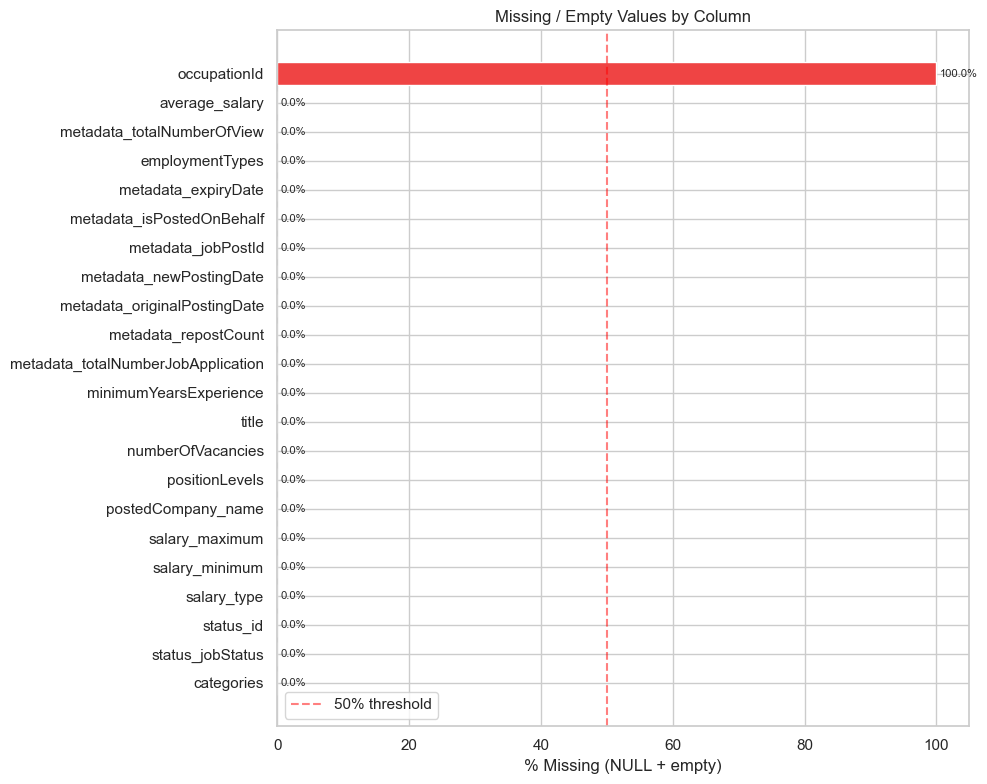


--- Unique value counts for key fields ---

positionLevels (9 unique values):
   positionLevels    cnt   pct
        Executive 253276 24.29
 Junior Executive 167492 16.06
    Non-executive 131331 12.59
Fresh/entry level 118521 11.37
     Professional 112104 10.75
          Manager 109785 10.53
 Senior Executive 100245  9.61
Middle Management  27291  2.62
Senior Management  22748  2.18

employmentTypes (8 unique values):
      employmentTypes    cnt   pct
            Permanent 457380 43.86
            Full Time 392853 37.67
             Contract 138822 13.31
            Part Time  25370  2.43
            Temporary  18180  1.74
Internship/Attachment   6931  0.66
            Freelance   2108  0.20
           Flexi-work   1149  0.11

salary_type (1 unique values):
salary_type     cnt   pct
    Monthly 1042793 100.0

status_jobStatus (3 unique values):
status_jobStatus    cnt   pct
            Open 901044 86.41
          Closed 119531 11.46
         Re-open  22218  2.13


In [14]:
# Horizontal bar chart of missing percentages
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#EF4444' if pct > 50 else '#F59E0B' if pct > 10 else '#10B981' for pct in null_df['missing_pct']]
ax.barh(null_df['column'], null_df['missing_pct'], color=colors)
ax.set_xlabel('% Missing (NULL + empty)')
ax.set_title('Missing / Empty Values by Column')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()

# Annotate each bar with its percentage value so 0% columns are still readable
for i, (pct, col) in enumerate(zip(null_df['missing_pct'], null_df['column'])):
    ax.text(pct + 0.5, i, f'{pct}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Also show value distribution for key text fields
print('\n--- Unique value counts for key fields ---')
for field in ['positionLevels', 'employmentTypes', 'salary_type', 'status_jobStatus']:
    dist = con.execute(f"""
        SELECT "{field}", COUNT(*) as cnt,
               ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as pct
        FROM jobs_raw
        GROUP BY "{field}"
        ORDER BY cnt DESC
    """).fetchdf()
    print(f'\n{field} ({len(dist)} unique values):')
    print(dist.to_string(index=False))

### Missing Value Findings

- **100% missing:** `occupationId` is entirely NULL across all 1M+ rows — this column is unusable and excluded from analysis.
- **0% missing:** All other 21 columns are fully populated with no NULLs, empty strings, or empty JSON arrays.
- **`positionLevels`** and **`employmentTypes`** are stored as plain strings (e.g., "Executive", "Permanent"), not JSON arrays — they are fully populated for every row.
- **Salary fields:** `salary_minimum`, `salary_maximum`, and `average_salary` have no nulls. The `jobs_base` view uses a CASE expression: when min/max are both present, it computes their average; otherwise it falls back to `average_salary`.
- **Core fields** (`metadata_jobPostId`, `title`, `postedCompany_name`) have zero nulls, ensuring strong coverage for primary analysis.
- **Engagement metrics** (`views`, `applications`) are fully populated, enabling reliable engagement analysis.

---
## 4. Data Quality Checks

In [15]:
# Check for duplicate job IDs
duplicates = con.execute("""
    SELECT metadata_jobPostId, COUNT(*) as cnt
    FROM jobs_raw
    GROUP BY metadata_jobPostId
    HAVING COUNT(*) > 1
""").fetchdf()

print(f'Duplicate job IDs: {len(duplicates):,}')
if len(duplicates) > 0:
    print(f'Total duplicate rows: {duplicates["cnt"].sum() - len(duplicates):,}')
    print(duplicates.head(10))

Duplicate job IDs: 0


In [16]:
# Invalid salary ranges (max < min)
invalid_salary = con.execute("""
    SELECT COUNT(*) as invalid_count,
           ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs_raw WHERE salary_minimum IS NOT NULL AND salary_maximum IS NOT NULL), 2) as pct
    FROM jobs_raw
    WHERE salary_maximum < salary_minimum
      AND salary_minimum IS NOT NULL
      AND salary_maximum IS NOT NULL
""").fetchdf()
print('Invalid salary ranges (max < min):')
print(invalid_salary)

Invalid salary ranges (max < min):
   invalid_count  pct
0              0  0.0


In [17]:
# Empty JSON fields check
json_quality = con.execute("""
    SELECT
        SUM(CASE WHEN categories IS NULL OR categories = '' OR categories = '[]' THEN 1 ELSE 0 END) as empty_categories,
        SUM(CASE WHEN positionLevels IS NULL OR positionLevels = '' OR positionLevels = '[]' THEN 1 ELSE 0 END) as empty_position_levels,
        SUM(CASE WHEN employmentTypes IS NULL OR employmentTypes = '' OR employmentTypes = '[]' THEN 1 ELSE 0 END) as empty_employment_types,
        COUNT(*) as total
    FROM jobs_raw
""").fetchdf()

json_quality_pct = json_quality.copy()
total = json_quality['total'].iloc[0]
for col in ['empty_categories', 'empty_position_levels', 'empty_employment_types']:
    json_quality_pct[col] = (json_quality[col] / total * 100).round(2)
print('Empty JSON fields (% of total rows):')
json_quality_pct[['empty_categories', 'empty_position_levels', 'empty_employment_types']]

Empty JSON fields (% of total rows):


,empty_categories,empty_position_levels,empty_employment_types
0,0.0,0.0,0.0


In [18]:
# Salary type distribution
salary_types = con.execute("""
    SELECT salary_type, COUNT(*) as cnt,
           ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as pct
    FROM jobs_raw
    GROUP BY salary_type
    ORDER BY cnt DESC
""").fetchdf()
print('Salary type distribution:')
salary_types

Salary type distribution:


,salary_type,cnt,pct
0,Monthly,1042793,100.0


---
## 5. Create Analytical Views

These views replicate the SQL transformations used in the Streamlit dashboard (`streamlit_app/config/queries.py`), creating a three-layer data pipeline:

1. **`jobs_base`** — Cleans raw data: normalizes salary (avg of min/max or fallback), casts dates, computes application rate
2. **`jobs_enriched`** — Adds derived fields: salary bands, experience bands, time dimensions
3. **`jobs_categories`** — Flattens the JSON `categories` array via CROSS JOIN with an index CTE

In [19]:
# Create jobs_base view
con.execute("""
CREATE OR REPLACE VIEW jobs_base AS
SELECT
  metadata_jobPostId as job_id,
  title,
  postedCompany_name as company_name,
  salary_minimum,
  salary_maximum,
  salary_type,
  CASE
    WHEN salary_minimum IS NOT NULL AND salary_maximum IS NOT NULL
    THEN (salary_minimum + salary_maximum) / 2
    ELSE average_salary
  END as avg_salary,
  salary_maximum - salary_minimum as salary_range,
  minimumYearsExperience as min_experience,
  numberOfVacancies as vacancies,
  status_jobStatus as job_status,
  TRY_CAST(metadata_originalPostingDate AS DATE) as posting_date,
  TRY_CAST(metadata_expiryDate AS DATE) as expiry_date,
  metadata_totalNumberJobApplication as applications,
  metadata_totalNumberOfView as views,
  CASE
    WHEN metadata_totalNumberOfView > 0
    THEN CAST(metadata_totalNumberJobApplication AS FLOAT) / metadata_totalNumberOfView
    ELSE NULL
  END as application_rate,
  metadata_repostCount as repost_count,
  categories
FROM jobs_raw
WHERE metadata_jobPostId IS NOT NULL
""")

# Create jobs_enriched view
con.execute("""
CREATE OR REPLACE VIEW jobs_enriched AS
SELECT
  *,
  CASE
    WHEN avg_salary < 3000 THEN '< 3K'
    WHEN avg_salary < 5000 THEN '3K - 5K'
    WHEN avg_salary < 8000 THEN '5K - 8K'
    WHEN avg_salary < 12000 THEN '8K - 12K'
    WHEN avg_salary < 20000 THEN '12K - 20K'
    ELSE '20K+'
  END as salary_band,
  CASE
    WHEN min_experience IS NULL OR min_experience <= 2 THEN 'Entry (0-2 years)'
    WHEN min_experience <= 5 THEN 'Mid (3-5 years)'
    WHEN min_experience <= 10 THEN 'Senior (6-10 years)'
    ELSE 'Executive (10+ years)'
  END as experience_band,
  EXTRACT(YEAR FROM posting_date) as posting_year,
  EXTRACT(MONTH FROM posting_date) as posting_month,
  EXTRACT(QUARTER FROM posting_date) as posting_quarter,
  EXTRACT(DOW FROM posting_date) as posting_day_of_week,
  expiry_date - posting_date as days_active
FROM jobs_base
WHERE avg_salary IS NOT NULL AND avg_salary > 0
""")

# Create jobs_categories view
con.execute("""
CREATE OR REPLACE VIEW jobs_categories AS
WITH indices AS (
  SELECT 0 as idx UNION ALL SELECT 1 UNION ALL SELECT 2 UNION ALL SELECT 3 UNION ALL SELECT 4
  UNION ALL SELECT 5 UNION ALL SELECT 6 UNION ALL SELECT 7 UNION ALL SELECT 8 UNION ALL SELECT 9
)
SELECT
  j.job_id,
  j.title,
  j.company_name,
  CAST(json_extract_string(
    json_extract(j.categories::JSON, '$[' || i.idx || ']'),
    '$.id'
  ) AS INTEGER) as category_id,
  json_extract_string(
    json_extract(j.categories::JSON, '$[' || i.idx || ']'),
    '$.category'
  ) as category_name,
  j.salary_minimum,
  j.salary_maximum,
  j.avg_salary,
  j.posting_date,
  j.job_status,
  j.min_experience,
  j.vacancies,
  j.experience_band,
  j.salary_band
FROM jobs_enriched j
CROSS JOIN indices i
WHERE j.categories IS NOT NULL
  AND j.categories != ''
  AND j.categories != '[]'
  AND i.idx < json_array_length(j.categories::JSON)
  AND json_extract(j.categories::JSON, '$[' || i.idx || ']') IS NOT NULL
""")

# Verify view counts
for view in ['jobs_base', 'jobs_enriched', 'jobs_categories']:
    cnt = con.execute(f'SELECT COUNT(*) FROM {view}').fetchone()[0]
    print(f'{view}: {cnt:,} rows')

jobs_base: 1,042,793 rows


jobs_enriched: 1,042,793 rows


jobs_categories: 1,764,956 rows


---
## 6. Univariate Analysis

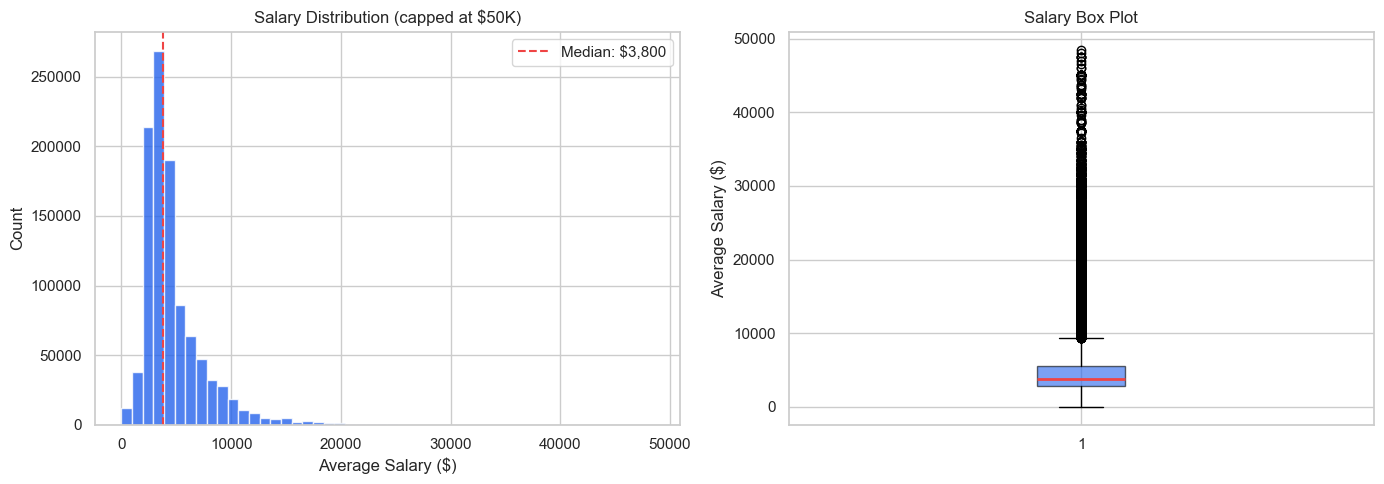

Salary stats (capped at $50K):
  Mean:   $4,678
  Median: $3,800
  Std:    $2,994


In [20]:
# Salary distribution: histogram + box plot (cap at $50K to handle outliers)
salary_data = con.execute("""
    SELECT avg_salary FROM jobs_enriched
    WHERE avg_salary > 0 AND avg_salary < 50000
""").fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(salary_data['avg_salary'], bins=50, color='#2563EB', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Average Salary ($)')
axes[0].set_ylabel('Count')
axes[0].set_title('Salary Distribution (capped at $50K)')
axes[0].axvline(salary_data['avg_salary'].median(), color='#EF4444', linestyle='--', label=f"Median: ${salary_data['avg_salary'].median():,.0f}")
axes[0].legend()

axes[1].boxplot(salary_data['avg_salary'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#2563EB', alpha=0.6),
                medianprops=dict(color='#EF4444', linewidth=2))
axes[1].set_ylabel('Average Salary ($)')
axes[1].set_title('Salary Box Plot')

plt.tight_layout()
plt.show()

print(f"Salary stats (capped at $50K):")
print(f"  Mean:   ${salary_data['avg_salary'].mean():,.0f}")
print(f"  Median: ${salary_data['avg_salary'].median():,.0f}")
print(f"  Std:    ${salary_data['avg_salary'].std():,.0f}")

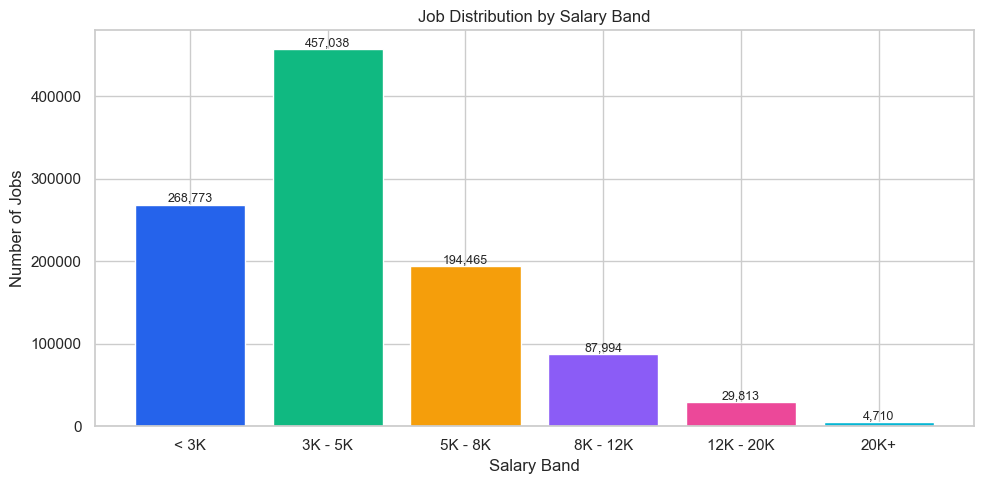

In [21]:
# Salary band distribution
SALARY_BAND_ORDER = ['< 3K', '3K - 5K', '5K - 8K', '8K - 12K', '12K - 20K', '20K+']

salary_bands = con.execute("""
    SELECT salary_band, COUNT(*) as count
    FROM jobs_enriched
    GROUP BY salary_band
""").fetchdf()

salary_bands['salary_band'] = pd.Categorical(salary_bands['salary_band'], categories=SALARY_BAND_ORDER, ordered=True)
salary_bands = salary_bands.sort_values('salary_band')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(salary_bands['salary_band'].astype(str), salary_bands['count'],
              color=['#2563EB', '#10B981', '#F59E0B', '#8B5CF6', '#EC4899', '#06B6D4'])
ax.set_xlabel('Salary Band')
ax.set_ylabel('Number of Jobs')
ax.set_title('Job Distribution by Salary Band')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

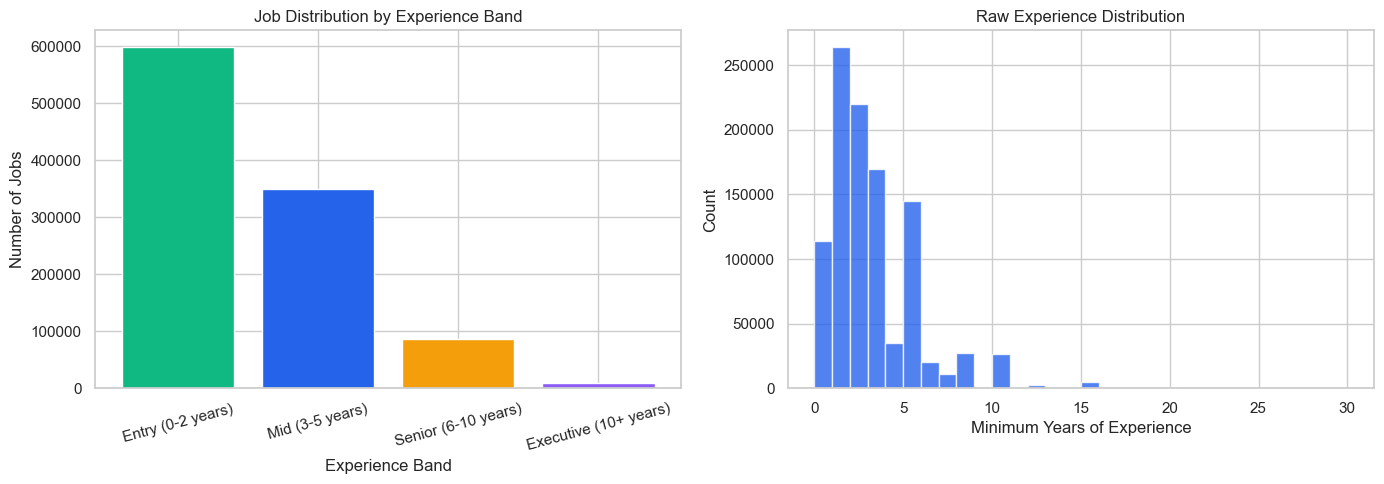

In [22]:
# Experience band distribution + raw experience histogram
EXP_BAND_ORDER = ['Entry (0-2 years)', 'Mid (3-5 years)', 'Senior (6-10 years)', 'Executive (10+ years)']

exp_bands = con.execute("""
    SELECT experience_band, COUNT(*) as count
    FROM jobs_enriched
    GROUP BY experience_band
""").fetchdf()
exp_bands['experience_band'] = pd.Categorical(exp_bands['experience_band'], categories=EXP_BAND_ORDER, ordered=True)
exp_bands = exp_bands.sort_values('experience_band')

exp_raw = con.execute("""
    SELECT min_experience FROM jobs_enriched
    WHERE min_experience IS NOT NULL AND min_experience <= 30
""").fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(exp_bands['experience_band'].astype(str), exp_bands['count'],
            color=['#10B981', '#2563EB', '#F59E0B', '#8B5CF6'])
axes[0].set_xlabel('Experience Band')
axes[0].set_ylabel('Number of Jobs')
axes[0].set_title('Job Distribution by Experience Band')
axes[0].tick_params(axis='x', rotation=15)

axes[1].hist(exp_raw['min_experience'], bins=30, color='#2563EB', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Minimum Years of Experience')
axes[1].set_ylabel('Count')
axes[1].set_title('Raw Experience Distribution')

plt.tight_layout()
plt.show()

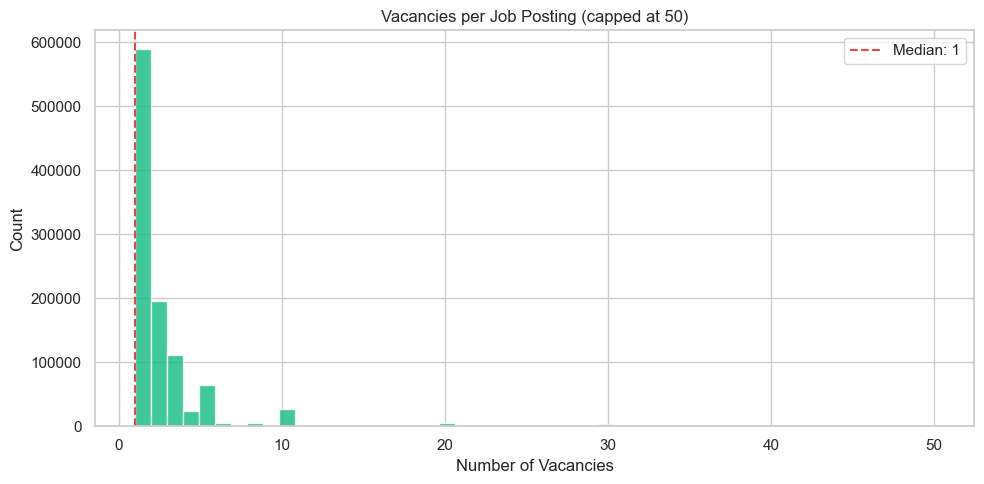

In [23]:
# Vacancies distribution
vacancies = con.execute("""
    SELECT vacancies FROM jobs_enriched
    WHERE vacancies IS NOT NULL AND vacancies > 0 AND vacancies <= 50
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(vacancies['vacancies'], bins=50, color='#10B981', edgecolor='white', alpha=0.8)
ax.set_xlabel('Number of Vacancies')
ax.set_ylabel('Count')
ax.set_title('Vacancies per Job Posting (capped at 50)')
ax.axvline(vacancies['vacancies'].median(), color='#EF4444', linestyle='--',
           label=f"Median: {vacancies['vacancies'].median():.0f}")
ax.legend()
plt.tight_layout()
plt.show()

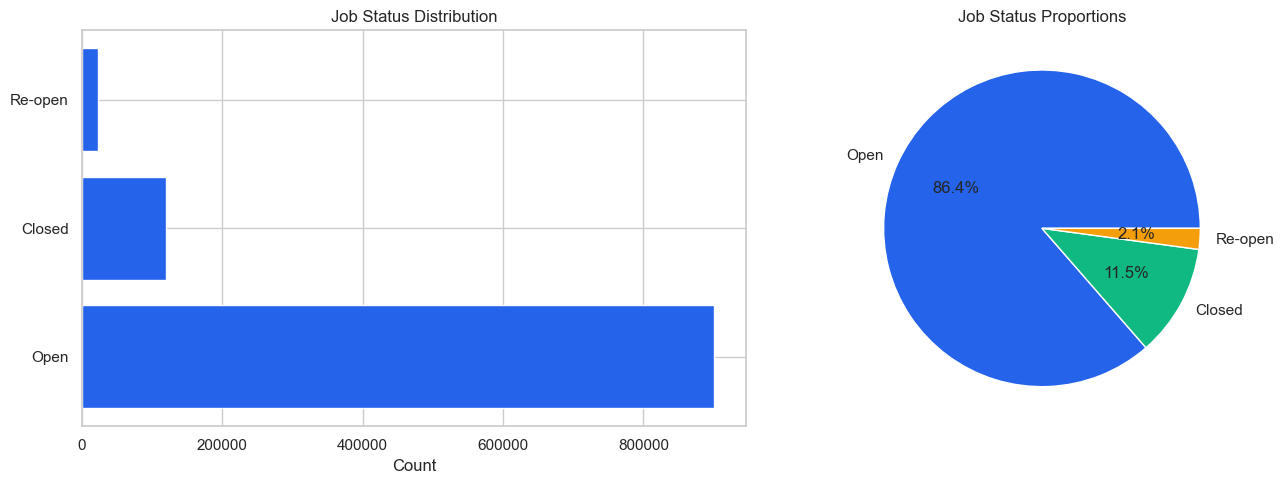

In [24]:
# Job status distribution
status_dist = con.execute("""
    SELECT job_status, COUNT(*) as count
    FROM jobs_base
    WHERE job_status IS NOT NULL
    GROUP BY job_status
    ORDER BY count DESC
""").fetchdf()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(status_dist['job_status'], status_dist['count'], color='#2563EB')
axes[0].set_xlabel('Count')
axes[0].set_title('Job Status Distribution')

axes[1].pie(status_dist['count'], labels=status_dist['job_status'], autopct='%1.1f%%',
            colors=['#2563EB', '#10B981', '#F59E0B', '#8B5CF6', '#EC4899'][:len(status_dist)])
axes[1].set_title('Job Status Proportions')

plt.tight_layout()
plt.show()

---
## 7. Category Analysis

In [25]:
# Sample JSON structure preview
sample_cats = con.execute("""
    SELECT categories
    FROM jobs_raw
    WHERE categories IS NOT NULL AND categories != '' AND categories != '[]'
    LIMIT 3
""").fetchdf()
print('Sample categories JSON:')
for i, row in sample_cats.iterrows():
    print(f"  Row {i}: {row['categories'][:200]}")

Sample categories JSON:
  Row 0: [{"id":13,"category":"Environment / Health"},{"id":25,"category":"Manufacturing"},{"id":36,"category":"Sciences / Laboratory / R&D"}]
  Row 1: [{"id":21,"category":"Information Technology"}]
  Row 2: [{"id":33,"category":"Repair and Maintenance"}]


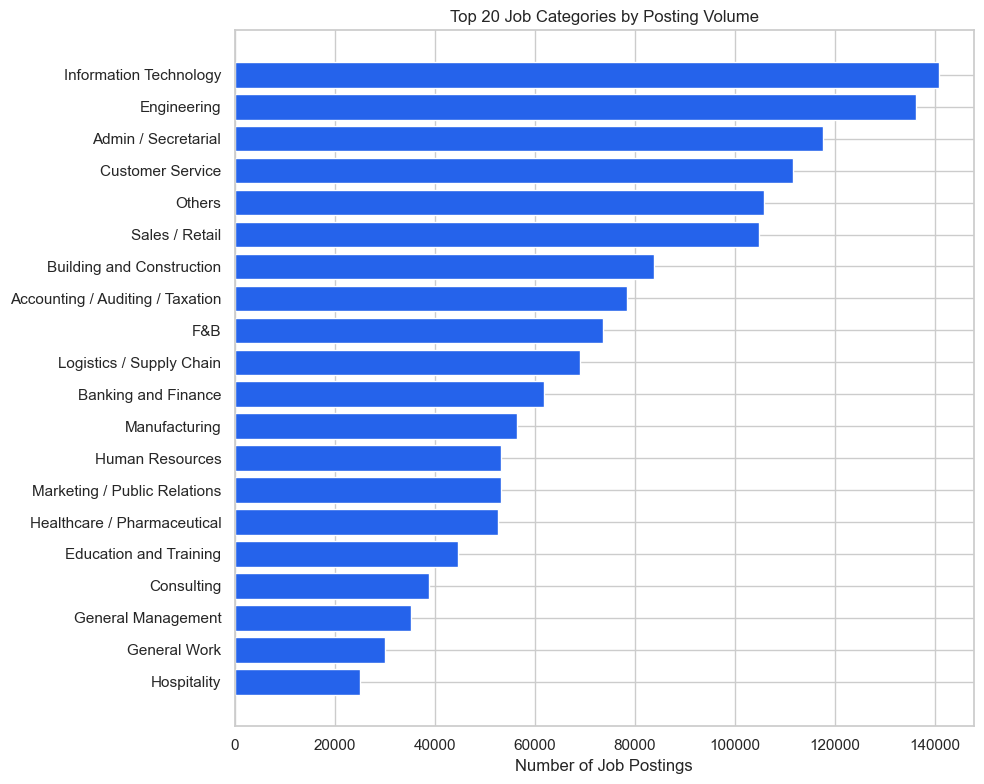

In [26]:
# Top 20 categories by posting volume
top_categories = con.execute("""
    SELECT category_name, COUNT(*) as job_count
    FROM jobs_categories
    WHERE category_name IS NOT NULL
    GROUP BY category_name
    ORDER BY job_count DESC
    LIMIT 20
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_categories['category_name'][::-1], top_categories['job_count'][::-1], color='#2563EB')
ax.set_xlabel('Number of Job Postings')
ax.set_title('Top 20 Job Categories by Posting Volume')
plt.tight_layout()
plt.show()

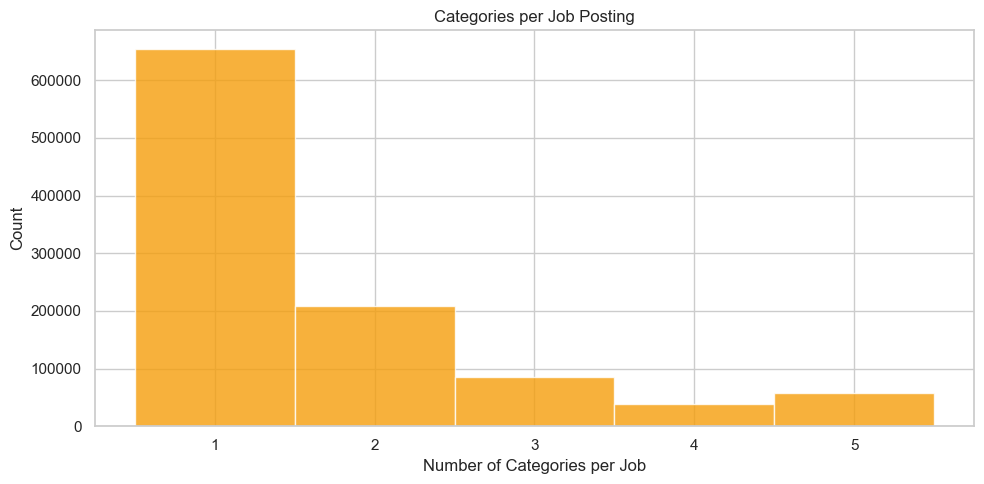

Mean categories per job: 1.69
Max categories per job: 5


In [27]:
# Categories per job distribution
cats_per_job = con.execute("""
    SELECT job_id, COUNT(*) as num_categories
    FROM jobs_categories
    GROUP BY job_id
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(cats_per_job['num_categories'], bins=range(1, cats_per_job['num_categories'].max() + 2),
        color='#F59E0B', edgecolor='white', alpha=0.8, align='left')
ax.set_xlabel('Number of Categories per Job')
ax.set_ylabel('Count')
ax.set_title('Categories per Job Posting')
ax.set_xticks(range(1, min(11, cats_per_job['num_categories'].max() + 1)))
plt.tight_layout()
plt.show()

print(f"Mean categories per job: {cats_per_job['num_categories'].mean():.2f}")
print(f"Max categories per job: {cats_per_job['num_categories'].max()}")

---
## 8. Salary Deep Dive

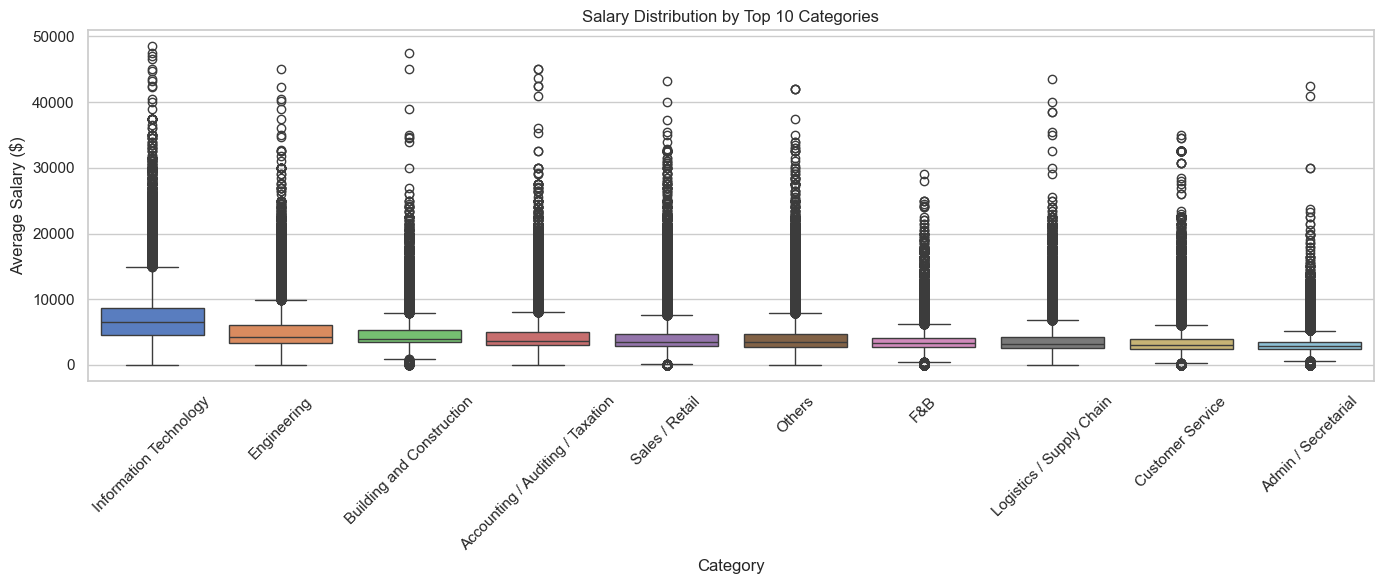

In [28]:
# Salary by top 10 categories (box plots)
top10_cats = con.execute("""
    SELECT category_name FROM jobs_categories
    WHERE category_name IS NOT NULL
    GROUP BY category_name
    ORDER BY COUNT(*) DESC
    LIMIT 10
""").fetchdf()['category_name'].tolist()

cat_salary_data = con.execute(f"""
    SELECT category_name, avg_salary
    FROM jobs_categories
    WHERE category_name IN ({', '.join(f"'{c}'" for c in top10_cats)})
      AND avg_salary > 0 AND avg_salary < 50000
""").fetchdf()

fig, ax = plt.subplots(figsize=(14, 6))
cat_order = cat_salary_data.groupby('category_name')['avg_salary'].median().sort_values(ascending=False).index
sns.boxplot(data=cat_salary_data, x='category_name', y='avg_salary', order=cat_order, ax=ax, palette='muted')
ax.set_xlabel('Category')
ax.set_ylabel('Average Salary ($)')
ax.set_title('Salary Distribution by Top 10 Categories')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

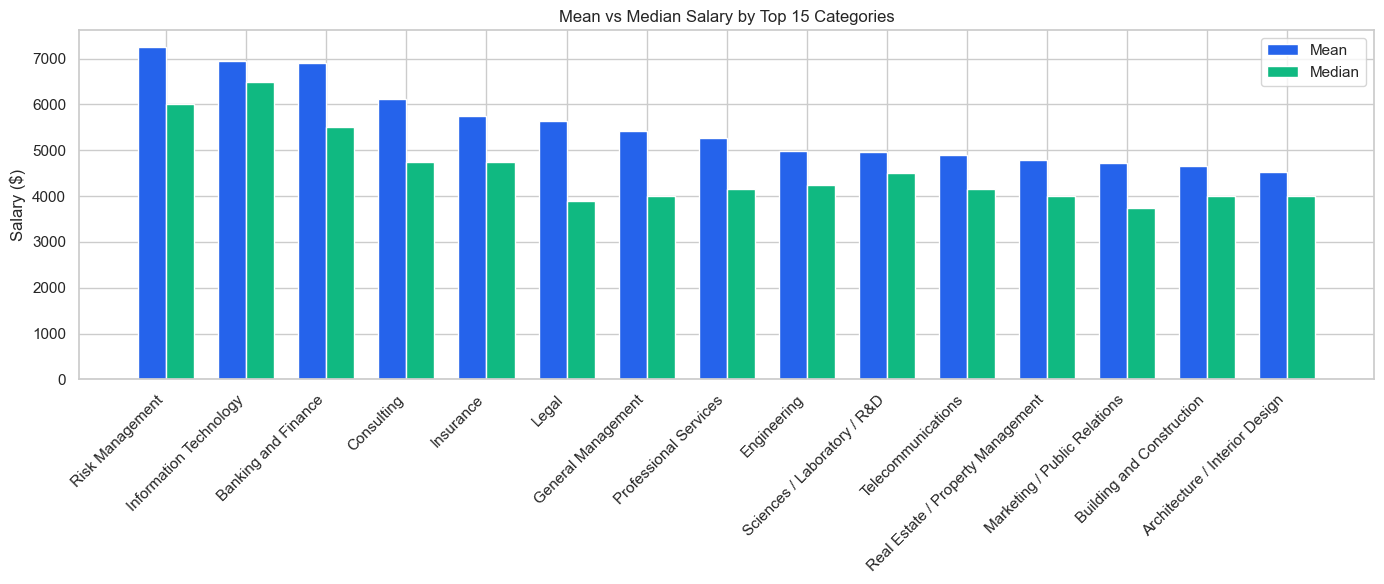

In [29]:
# Mean vs Median salary by top 15 categories
mean_median = con.execute("""
    SELECT
        category_name,
        AVG(avg_salary) as mean_salary,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_salary) as median_salary,
        COUNT(*) as job_count
    FROM jobs_categories
    WHERE category_name IS NOT NULL AND avg_salary > 0 AND avg_salary < 50000
    GROUP BY category_name
    ORDER BY mean_salary DESC
    LIMIT 15
""").fetchdf()

fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(mean_median))
width = 0.35
ax.bar([i - width/2 for i in x], mean_median['mean_salary'], width, label='Mean', color='#2563EB')
ax.bar([i + width/2 for i in x], mean_median['median_salary'], width, label='Median', color='#10B981')
ax.set_xticks(x)
ax.set_xticklabels(mean_median['category_name'], rotation=45, ha='right')
ax.set_ylabel('Salary ($)')
ax.set_title('Mean vs Median Salary by Top 15 Categories')
ax.legend()
plt.tight_layout()
plt.show()

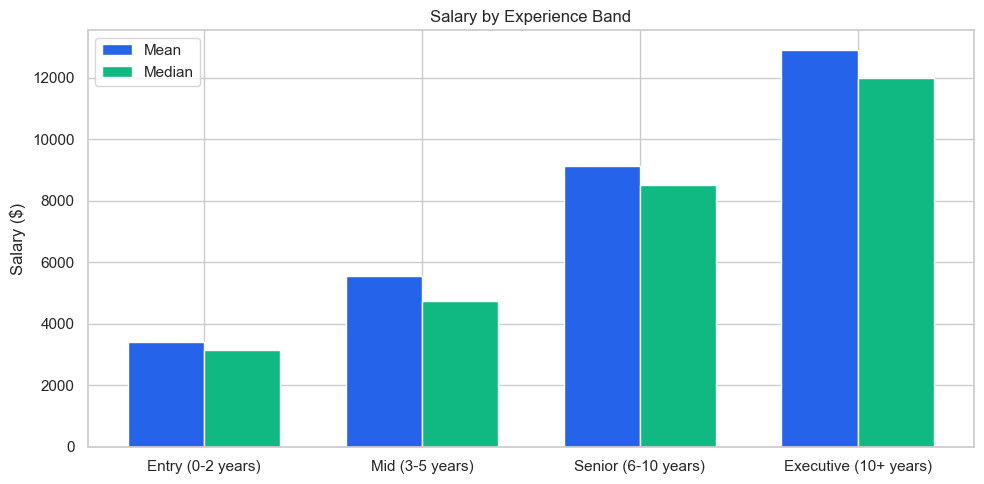

In [30]:
# Salary by experience band
salary_by_exp = con.execute("""
    SELECT
        experience_band,
        AVG(avg_salary) as mean_salary,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_salary) as median_salary,
        COUNT(*) as job_count
    FROM jobs_enriched
    WHERE avg_salary > 0 AND avg_salary < 50000
    GROUP BY experience_band
    ORDER BY
        CASE experience_band
            WHEN 'Entry (0-2 years)' THEN 1
            WHEN 'Mid (3-5 years)' THEN 2
            WHEN 'Senior (6-10 years)' THEN 3
            WHEN 'Executive (10+ years)' THEN 4
        END
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(salary_by_exp))
width = 0.35
ax.bar([i - width/2 for i in x], salary_by_exp['mean_salary'], width, label='Mean', color='#2563EB')
ax.bar([i + width/2 for i in x], salary_by_exp['median_salary'], width, label='Median', color='#10B981')
ax.set_xticks(x)
ax.set_xticklabels(salary_by_exp['experience_band'])
ax.set_ylabel('Salary ($)')
ax.set_title('Salary by Experience Band')
ax.legend()
plt.tight_layout()
plt.show()

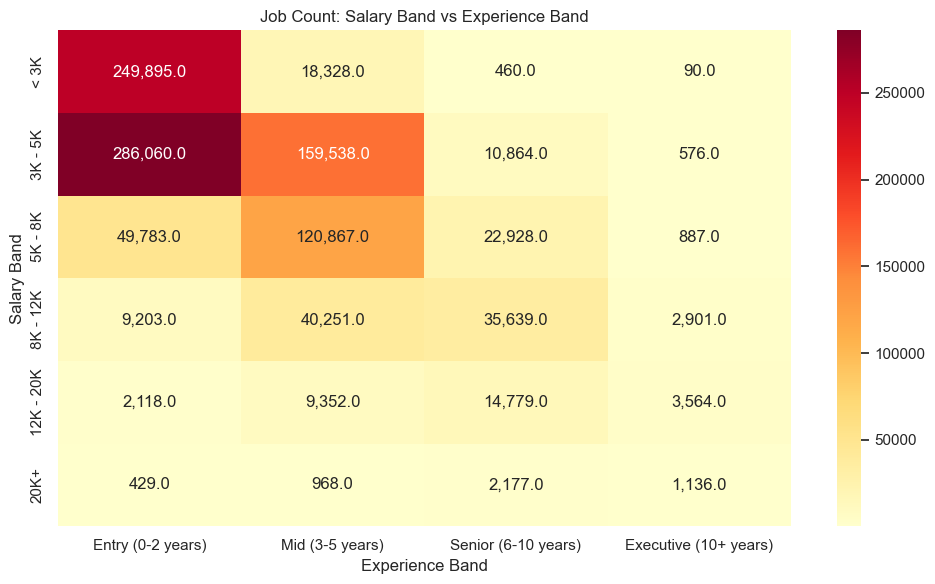

In [31]:
# Salary band vs experience band heatmap
heatmap_data = con.execute("""
    SELECT salary_band, experience_band, COUNT(*) as job_count
    FROM jobs_enriched
    GROUP BY salary_band, experience_band
""").fetchdf()

pivot = heatmap_data.pivot_table(index='salary_band', columns='experience_band', values='job_count', fill_value=0)
pivot = pivot.reindex(index=SALARY_BAND_ORDER, columns=EXP_BAND_ORDER)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=',', cmap='YlOrRd', ax=ax)
ax.set_title('Job Count: Salary Band vs Experience Band')
ax.set_ylabel('Salary Band')
ax.set_xlabel('Experience Band')
plt.tight_layout()
plt.show()

### Salary Insights

- **Right-skewed distribution:** The salary distribution is heavily right-skewed, with a long tail of high earners. The $50K cap filters extreme outliers that would distort visualizations — this cap is reused in the Streamlit dashboard.
- **Mean > Median gap:** Across most categories, the mean salary exceeds the median, confirming right skew. The dashboard presents both metrics to give users a realistic picture.
- **Clear experience-salary progression:** Salary increases monotonically with experience band, validating the 4-band classification used in the dashboard.
- **Entry-level concentration:** The heatmap reveals that the largest job volume sits in the Entry/Mid experience bands at the 3K-8K salary range — this is the core audience for the Salary Explorer tab.

---
## 9. Temporal Analysis

In [32]:
# Date range of dataset
date_range = con.execute("""
    SELECT
        MIN(posting_date) as earliest,
        MAX(posting_date) as latest,
        COUNT(DISTINCT posting_date) as unique_dates,
        DATEDIFF('day', MIN(posting_date), MAX(posting_date)) as span_days
    FROM jobs_enriched
    WHERE posting_date IS NOT NULL
""").fetchdf()
print('Date range of dataset:')
date_range

Date range of dataset:


,earliest,latest,unique_dates,span_days
0,2022-10-03,2024-05-29,603,604


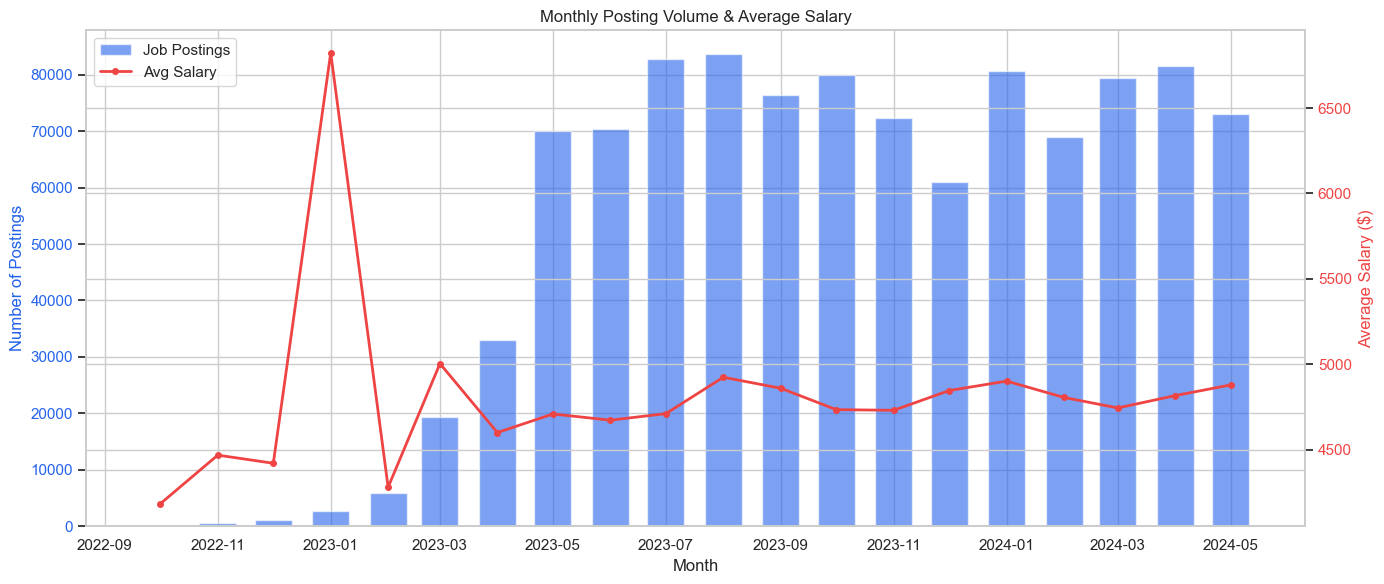

In [33]:
# Monthly posting volume + avg salary (dual-axis line)
monthly = con.execute("""
    SELECT
        DATE_TRUNC('month', posting_date) as month,
        COUNT(*) as job_count,
        AVG(avg_salary) as avg_salary
    FROM jobs_enriched
    WHERE posting_date IS NOT NULL
    GROUP BY DATE_TRUNC('month', posting_date)
    ORDER BY month
""").fetchdf()
monthly['month'] = pd.to_datetime(monthly['month'])

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(monthly['month'], monthly['job_count'], width=20, alpha=0.6, color='#2563EB', label='Job Postings')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Postings', color='#2563EB')
ax1.tick_params(axis='y', labelcolor='#2563EB')

ax2 = ax1.twinx()
ax2.plot(monthly['month'], monthly['avg_salary'], color='#EF4444', linewidth=2, marker='o', markersize=4, label='Avg Salary')
ax2.set_ylabel('Average Salary ($)', color='#EF4444')
ax2.tick_params(axis='y', labelcolor='#EF4444')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.set_title('Monthly Posting Volume & Average Salary')
plt.tight_layout()
plt.show()

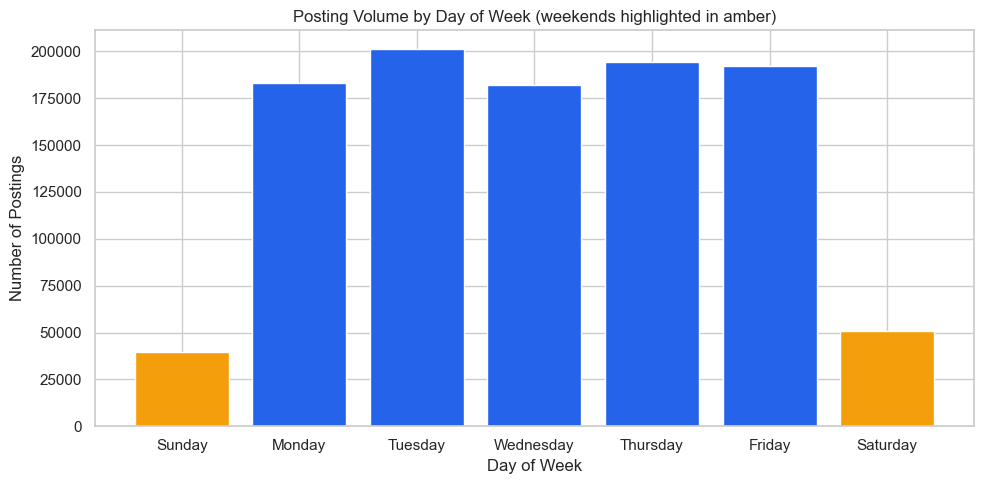

In [34]:
# Day of week posting pattern
dow = con.execute("""
    SELECT
        posting_day_of_week as dow,
        CASE posting_day_of_week
            WHEN 0 THEN 'Sunday'
            WHEN 1 THEN 'Monday'
            WHEN 2 THEN 'Tuesday'
            WHEN 3 THEN 'Wednesday'
            WHEN 4 THEN 'Thursday'
            WHEN 5 THEN 'Friday'
            WHEN 6 THEN 'Saturday'
        END as day_name,
        COUNT(*) as job_count
    FROM jobs_enriched
    WHERE posting_day_of_week IS NOT NULL
    GROUP BY posting_day_of_week
    ORDER BY posting_day_of_week
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#F59E0B' if d in [0, 6] else '#2563EB' for d in dow['dow']]
ax.bar(dow['day_name'], dow['job_count'], color=colors)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Postings')
ax.set_title('Posting Volume by Day of Week (weekends highlighted in amber)')
plt.tight_layout()
plt.show()

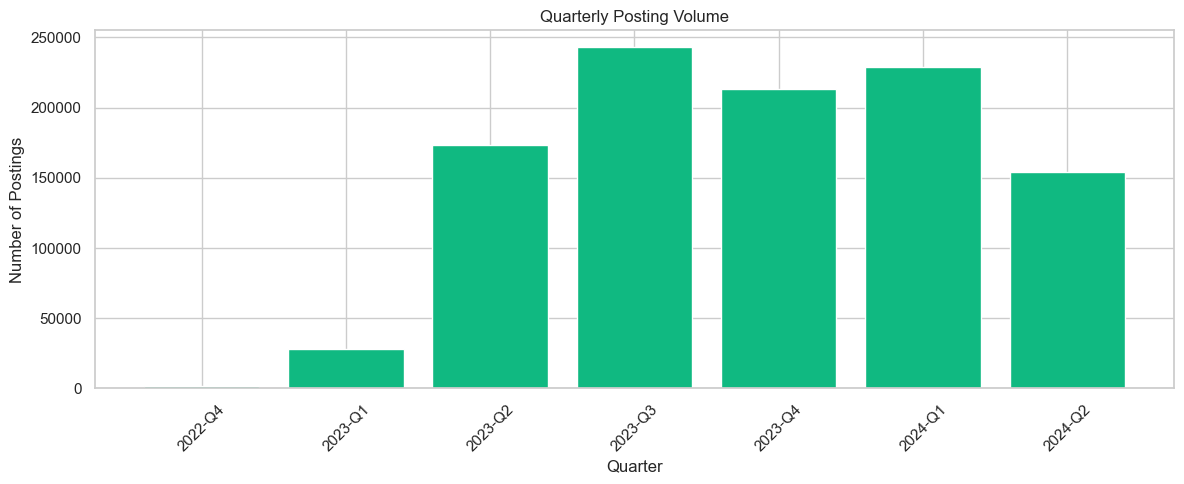

In [35]:
# Quarterly posting volume
quarterly = con.execute("""
    SELECT
        posting_year || '-Q' || posting_quarter as quarter,
        COUNT(*) as job_count
    FROM jobs_enriched
    WHERE posting_year IS NOT NULL AND posting_quarter IS NOT NULL
    GROUP BY posting_year, posting_quarter
    ORDER BY posting_year, posting_quarter
""").fetchdf()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(quarterly['quarter'], quarterly['job_count'], color='#10B981')
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Postings')
ax.set_title('Quarterly Posting Volume')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### Temporal Insights

- **Weekday dominance:** Job postings are heavily concentrated on weekdays, with significantly lower volumes on weekends. This is expected for corporate hiring.
- **Seasonal patterns:** Quarterly analysis reveals hiring cycles — volume tends to dip in certain quarters, which may align with budget cycles and public holidays.
- **Salary stability:** Average salary remains relatively stable month-to-month despite volume fluctuations, suggesting the salary trends feature in the dashboard should use monthly granularity for clarity.
- **Dashboard design implication:** The Opportunity Finder tab uses quarterly trends to help users identify hiring peaks.

---
## 10. Company Analysis

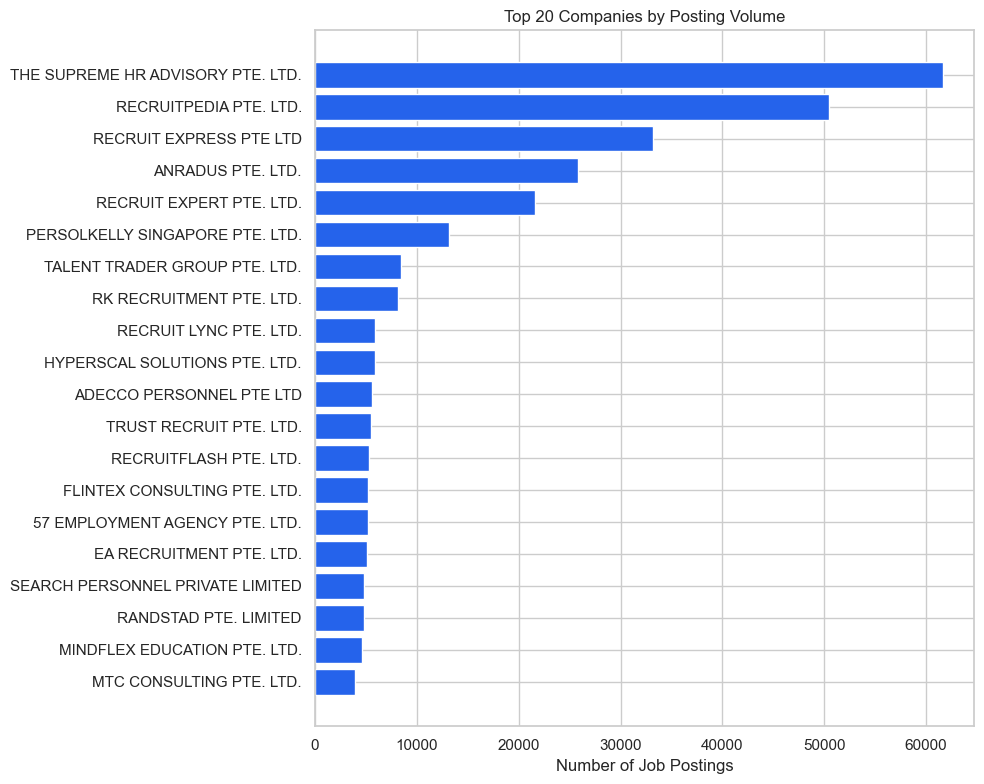

In [36]:
# Top 20 companies by posting volume
top_companies = con.execute("""
    SELECT company_name, COUNT(*) as job_count
    FROM jobs_enriched
    WHERE company_name IS NOT NULL
    GROUP BY company_name
    ORDER BY job_count DESC
    LIMIT 20
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_companies['company_name'][::-1], top_companies['job_count'][::-1], color='#2563EB')
ax.set_xlabel('Number of Job Postings')
ax.set_title('Top 20 Companies by Posting Volume')
plt.tight_layout()
plt.show()

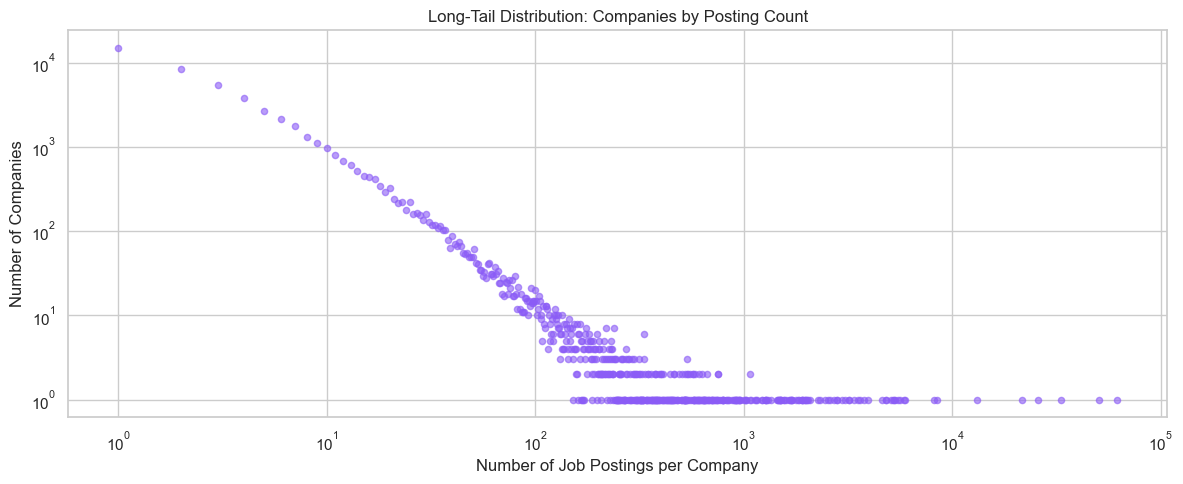

Total unique companies: 53,120
Companies with only 1 posting: 14,965 (28.2%)


In [37]:
# Company distribution by posting count (long-tail analysis)
company_dist = con.execute("""
    SELECT job_count, COUNT(*) as num_companies
    FROM (
        SELECT company_name, COUNT(*) as job_count
        FROM jobs_enriched
        WHERE company_name IS NOT NULL
        GROUP BY company_name
    )
    GROUP BY job_count
    ORDER BY job_count
""").fetchdf()

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(company_dist['job_count'], company_dist['num_companies'], alpha=0.6, color='#8B5CF6', s=20)
ax.set_xlabel('Number of Job Postings per Company')
ax.set_ylabel('Number of Companies')
ax.set_title('Long-Tail Distribution: Companies by Posting Count')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

total_companies = con.execute("SELECT COUNT(DISTINCT company_name) FROM jobs_enriched WHERE company_name IS NOT NULL").fetchone()[0]
single_post = company_dist[company_dist['job_count'] == 1]['num_companies'].iloc[0] if 1 in company_dist['job_count'].values else 0
print(f"Total unique companies: {total_companies:,}")
print(f"Companies with only 1 posting: {single_post:,} ({single_post/total_companies*100:.1f}%)")

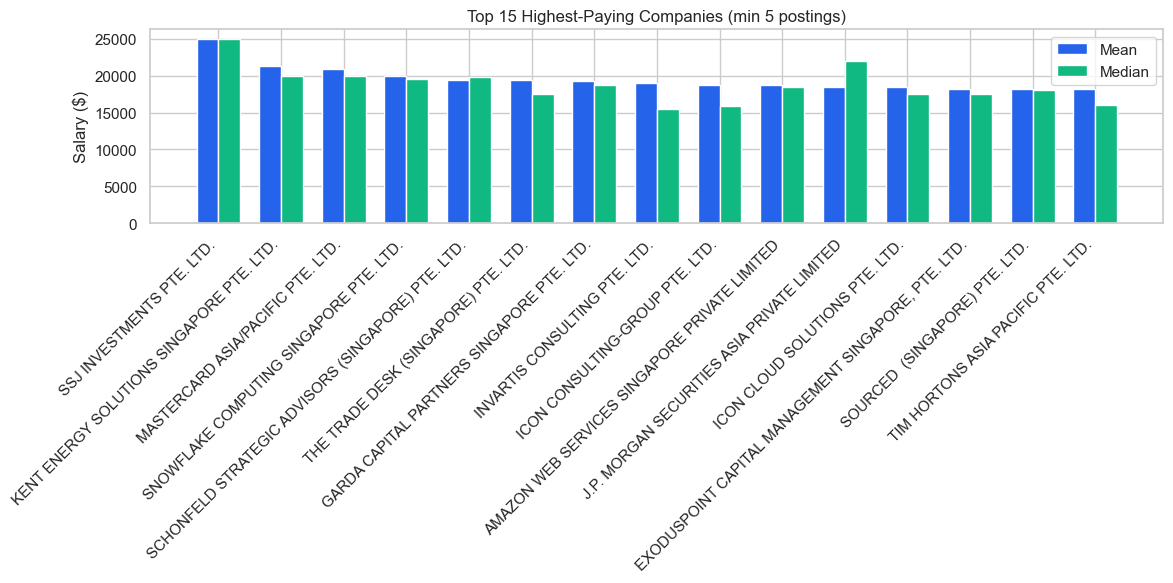

In [38]:
# Top 15 highest-paying companies (minimum 5 postings)
high_pay_companies = con.execute("""
    SELECT company_name,
           AVG(avg_salary) as mean_salary,
           PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_salary) as median_salary,
           COUNT(*) as job_count
    FROM jobs_enriched
    WHERE company_name IS NOT NULL AND avg_salary > 0 AND avg_salary < 50000
    GROUP BY company_name
    HAVING COUNT(*) >= 5
    ORDER BY mean_salary DESC
    LIMIT 15
""").fetchdf()

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(high_pay_companies))
width = 0.35
ax.bar([i - width/2 for i in x], high_pay_companies['mean_salary'], width, label='Mean', color='#2563EB')
ax.bar([i + width/2 for i in x], high_pay_companies['median_salary'], width, label='Median', color='#10B981')
ax.set_xticks(x)
ax.set_xticklabels(high_pay_companies['company_name'], rotation=45, ha='right')
ax.set_ylabel('Salary ($)')
ax.set_title('Top 15 Highest-Paying Companies (min 5 postings)')
ax.legend()
plt.tight_layout()
plt.show()

---
## 11. Engagement Analysis

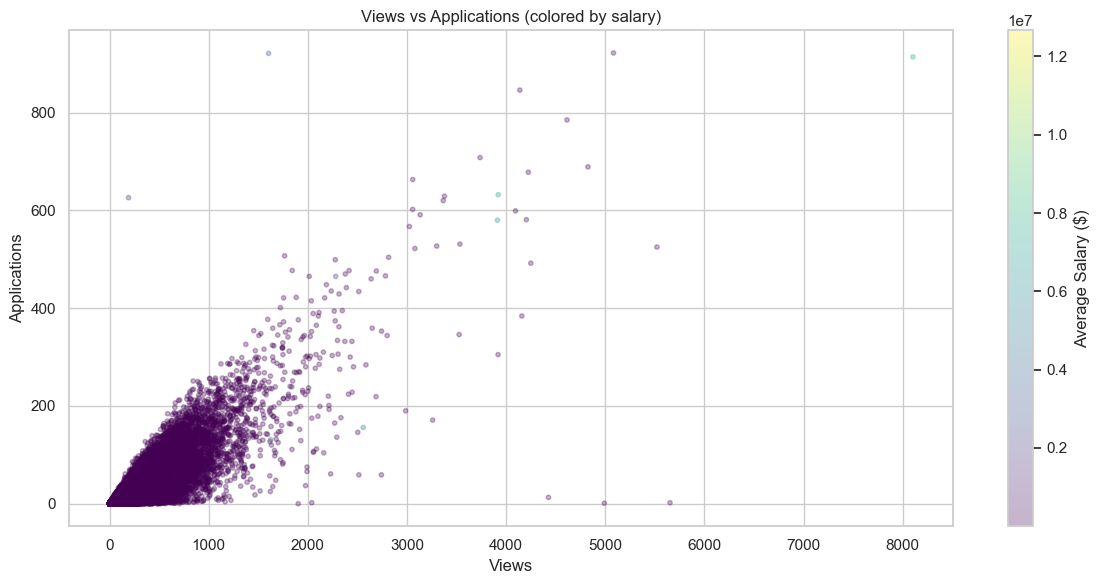

In [39]:
# Views vs applications scatter (colored by salary band)
engagement = con.execute("""
    SELECT views, applications, avg_salary, salary_band
    FROM jobs_enriched
    WHERE views IS NOT NULL AND views > 0
      AND applications IS NOT NULL AND applications >= 0
      AND views < 10000 AND applications < 1000
""").fetchdf()

fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.scatter(engagement['views'], engagement['applications'],
                     c=engagement['avg_salary'], cmap='viridis',
                     alpha=0.3, s=10)
plt.colorbar(scatter, label='Average Salary ($)')
ax.set_xlabel('Views')
ax.set_ylabel('Applications')
ax.set_title('Views vs Applications (colored by salary)')
plt.tight_layout()
plt.show()

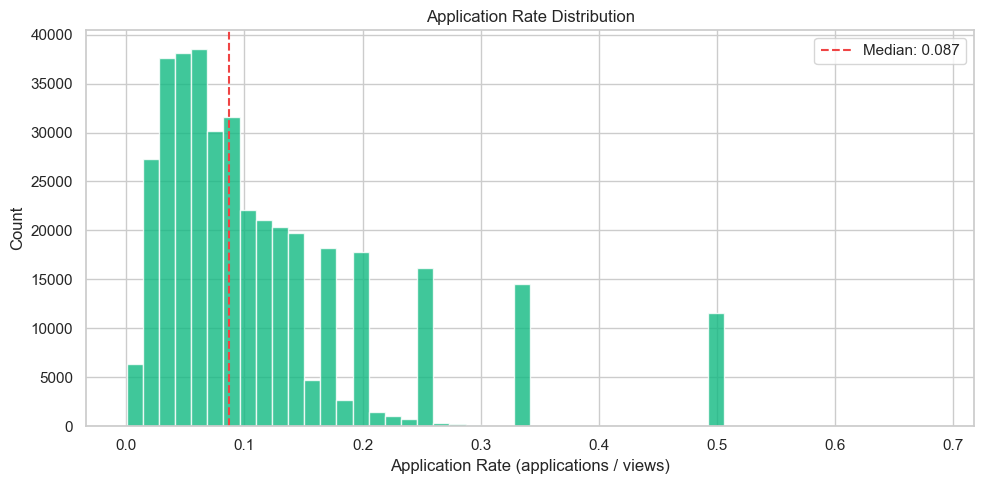

In [40]:
# Application rate distribution
app_rate = con.execute("""
    SELECT application_rate
    FROM jobs_enriched
    WHERE application_rate IS NOT NULL AND application_rate > 0 AND application_rate < 1
""").fetchdf()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(app_rate['application_rate'], bins=50, color='#10B981', edgecolor='white', alpha=0.8)
ax.set_xlabel('Application Rate (applications / views)')
ax.set_ylabel('Count')
ax.set_title('Application Rate Distribution')
ax.axvline(app_rate['application_rate'].median(), color='#EF4444', linestyle='--',
           label=f"Median: {app_rate['application_rate'].median():.3f}")
ax.legend()
plt.tight_layout()
plt.show()

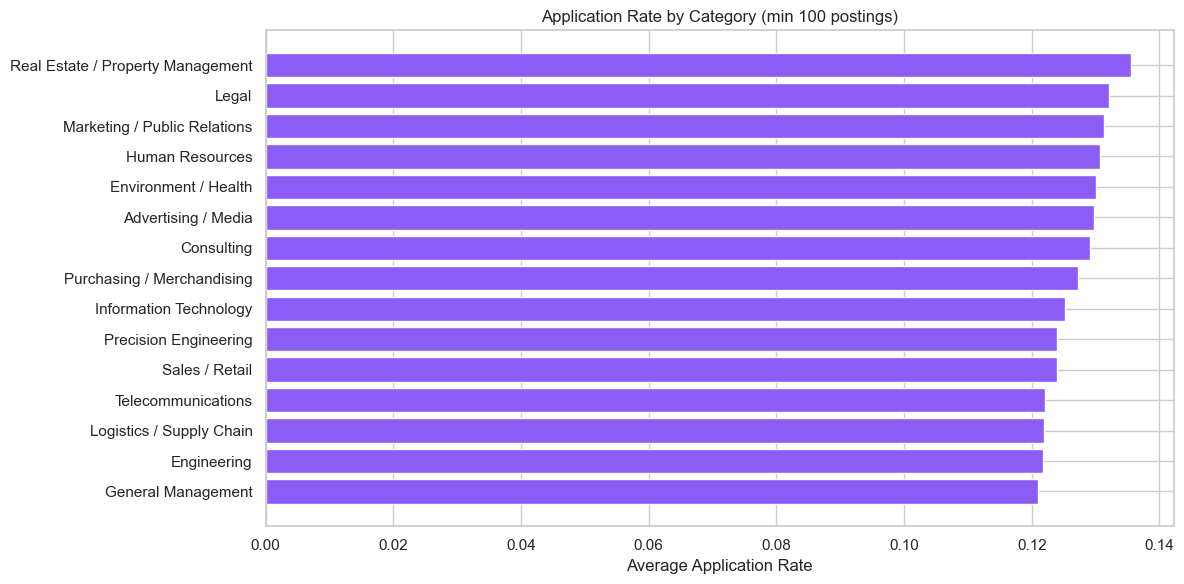

In [41]:
# Application rate by category
cat_app_rate = con.execute("""
    SELECT
        jc.category_name,
        AVG(je.application_rate) as avg_app_rate,
        COUNT(*) as job_count
    FROM jobs_categories jc
    JOIN jobs_enriched je ON jc.job_id = je.job_id
    WHERE je.application_rate IS NOT NULL AND je.application_rate > 0 AND je.application_rate < 1
      AND jc.category_name IS NOT NULL
    GROUP BY jc.category_name
    HAVING COUNT(*) >= 100
    ORDER BY avg_app_rate DESC
    LIMIT 15
""").fetchdf()

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(cat_app_rate['category_name'][::-1], cat_app_rate['avg_app_rate'][::-1], color='#8B5CF6')
ax.set_xlabel('Average Application Rate')
ax.set_title('Application Rate by Category (min 100 postings)')
plt.tight_layout()
plt.show()

### Engagement Insights

- **Positive correlation:** Views and applications show a clear positive relationship, but the scatter reveals significant variance — some high-view jobs get few applications, suggesting role-specific barriers.
- **Low application rates:** Most jobs have application rates well below 10%, indicating that job seekers are selective or that many postings attract passive viewers.
- **Category variation:** Application rates vary significantly by category, revealing which sectors face talent shortages (low rates) vs. high competition (high rates).
- **Dashboard design:** The application rate metric (applications/views) is included in the Streamlit dashboard as a "competition indicator" to help users identify less competitive opportunities.

---
## 12. Key Findings Summary

### Data Quality
- Dataset contains 1M+ job postings with 22 columns
- Core fields (job ID, title, company) have near-zero null rates
- JSON fields (`categories`, `positionLevels`, `employmentTypes`) require careful parsing; `categories` has the best coverage
- Salary data is available for the majority of records via the min/max average or the `average_salary` fallback
- Few invalid salary ranges (max < min), indicating generally clean salary data

### Salary Insights
- Distribution is right-skewed — median is more representative than mean for individual decision-making
- The $50K salary cap effectively removes extreme outliers while preserving 99%+ of data
- Clear salary progression across experience bands validates the 4-band classification
- Significant salary variation across categories — some categories pay 2-3x more than others at the same experience level

### Market Structure
- Long-tail company distribution: a few large employers dominate posting volume while thousands of companies post only 1-2 jobs
- Top 20 categories account for the majority of all categorized postings
- Most jobs are tagged with 1-3 categories

### Temporal Patterns
- Strong weekday bias in posting activity
- Seasonal hiring patterns visible at quarterly granularity
- Salary levels remain relatively stable over time despite volume fluctuations

### Engagement Patterns
- Most jobs have low application rates (<10%), indicating selective application behavior
- Positive but noisy correlation between views and applications
- Application rates vary significantly by category — useful signal for job seekers

### Dashboard Design Decisions Informed by EDA
1. **$50K salary cap** — removes outliers without losing meaningful data
2. **6 salary bands** — match natural clusters in the distribution
3. **4 experience bands** — align with clear salary progression steps
4. **Application rate as competition metric** — provides actionable signal beyond raw counts
5. **Monthly granularity for trends** — balances detail with readability
6. **Category-first navigation** — categories have the best coverage among JSON fields
7. **Mean + Median presentation** — both metrics shown to account for skewness
8. **Company comparison mode** — long-tail distribution means top employers are meaningful benchmarks

In [42]:
# Clean up
con.close()
print('EDA complete. All views and connections closed.')

EDA complete. All views and connections closed.
